# Displaying tif data

## Import packages

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

Load the s3 utility fuctions to load/upload files

In [14]:
import sys

sys.path.append("../utils")
from s3 import S3Bucket

## Create an instance of the S3Bucket class

Replace the credentials path with your own.

### For Windows users

In [17]:
credentials_path = r"C:\Users\Jules\.aws\\"

### For MacOs and linux users

In [52]:
credentials_path = r""

### Load credentials

In [18]:
# The following code is to get the credentials from the .aws folder
# r is to avoid the \ being interpreted as an escape character

with open(credentials_path + "credentials", "r") as f:
    lines = f.readlines()
    for line in lines:
        if "aws_access_key_id" in line:
            aws_access_key_id = line.split("=")[1].strip()
        if "aws_secret_access_key" in line:
            aws_secret_key = line.split("=")[1].strip()

with open(credentials_path + "config", "r") as f:
    lines = f.readlines()
    for line in lines:
        if "region" in line:
            region_name = line.split("=")[1].strip()

bucket_names = ["alert-api", "risk"]

s3 = S3Bucket(
    bucket_name=bucket_names[1],
    endpoint_url="https://s3." + region_name + ".io.cloud.ovh.net/",
    region_name=region_name,
    aws_access_key_id=aws_access_key_id,
    aws_secret_key=aws_secret_key,
)

### Check the files in the bucket

In [19]:
_ = s3.list_files()

List all different file extensions in the bucket


In [22]:
file_extensions = []
for file in _:
    file_extensions.append(file.split(".")[-1])
file_extensions = list(set(file_extensions))
print(f"File extensions in the bucket: \n {file_extensions}")

File extensions in the bucket: 
 ['gdb/timestamps', 'gdbtable', 'gdbtablx', 'freelist', 'SAMPLE', 'TFw', 'zip', 'TIF', 'nc', 'csv', 'gpkg', 'cpg', 'DS_Store', 'tfw', 'spx', 'geojson', 'txt', 'dbf', 'tif', 'gdb/gdb', 'atx', 'sld', 'gdbindexes', 'qml', 'doc', 'prj', 'pdf', 'shp', 'xml', 'shx', 'hdf', 'xls', 'lyr', 'json', 'ovr']


We will study the .tif files which are raster files.

In [21]:
tif_files = s3.list_files(pattern=".tif")
print(f"Number of tif files: {len(tif_files)}")

Number of tif files: 571


In [24]:
tif_files[0]

'Corine_Land_Cover/u2018_clc2018_v2020_20u1_raster100m/DATA/French_DOMs/U2018_CLC2018_V2020_20u1_FR_GLP.tif'

## Tif analysis process

### Downloading a file from the bucket

In [26]:
file_name = "test.tif"
s3.download_file(tif_files[0], file_name)

### Loads the tif file as a rasterio object

Display base information about the dataset according to the rasterio documentation (https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html)


In [54]:
dataset = rasterio.open(file_name)

print("Information about the TIFF file:")
print("--------------------")
# TODO: add more information about the file
print(f"File name: {dataset.name}")
print(f"Data type: {dataset.dtypes[0]}")
print(f"Number of raster bands: {dataset.count}")
print(f"Dimensions: {dataset.width} x {dataset.height}")

print("\nGeographic information:")
print("--------------------")
print(f"Reference coordinate system: {dataset.crs}")
print(f"Spatial coordinates of the corners: {dataset.bounds}")
print(f"Spatial resolution: {dataset.res}")
print(f"Geographic coordinates of the dataset's center (lon, lat): {dataset.lnglat()}")
# TODO: find how to get the geographic coordinates of any points, not only the center

print(f"Transform matrix: \n{dataset.transform}\n")

# Read the lattiude and longitude coordinates from the dataset
# These coordinates
lat = dataset.xy(0, 0)[1]
lon = dataset.xy(0, 0)[0]

print(
    f"Geographic coordinates of the top left corner relative to the CRS (lon, lat): {dataset.transform * (lat, lon)}"
)

Information about the TIFF file:
--------------------
File name: test.tif
Data type: uint8
Number of raster bands: 1
Dimensions: 1063 x 957

Geographic information:
--------------------
Reference coordinate system: EPSG:4559
Spatial coordinates of the corners: BoundingBox(left=617151.000324164, bottom=1740782.1579604005, right=723451.000324164, top=1836482.1579604005)
Spatial resolution: (100.0, 100.0)
Geographic coordinates of the dataset's center (lon, lat): (-61.407080232765665, 16.172103685047677)
Transform matrix: 
| 100.00, 0.00, 617151.00|
| 0.00,-100.00, 1836482.16|
| 0.00, 0.00, 1.00|

Geographic coordinates of the top left corner relative to the CRS (lon, lat): (184260366.79636422, -59883617.874456)


### Explanaition of the code above

```python	
>>> dataset.bounds
BoundingBox(left=358485.0, bottom=4028985.0, right=590415.0, top=4265115.0)
```
Means that  the map covers the world from 358485 meters (in this case) to 590415 meters, left to right, and 4028985 meters to 4265115 meters bottom to top. It covers a region 231.93 kilometers wide by 236.13 kilometers high. (https://rasterio.readthedocs.io/en/latest/quickstart.html)

You can check on this website that the coordinates of the dataset's center are correct: https://www.latlong.net/Show-Latitude-Longitude.html
For instance, (-61.407080232765665, 16.172103685047677) corresponds to Guadeloupe. 

### Plot the raster data

We can check whether the location found through the coordinates is correct by plotting the dataset on a map.

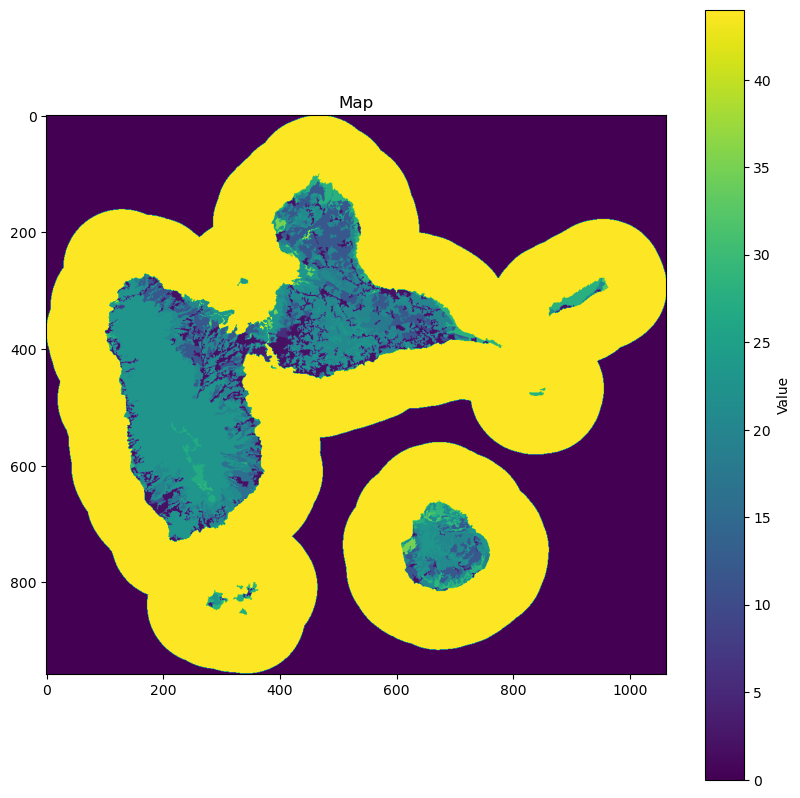

In [37]:
dataset = rasterio.open(file_name)

data = dataset.read(1)

plt.figure(figsize=(10, 10))
plt.imshow(data, cmap="viridis")
plt.colorbar(label="Value, unit = ?") 
plt.title("Map")
plt.show()

dataset.close()